In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [445]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'search_mode': 'fast',
    'scoring': 'gnina',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# neural_oracle = NeuralOracle(
#     'Mpro affinity',
#     state_dict_path='../../dgym-data/neural/asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
# )

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8.5, 10_000),
    acceptable=(6, 10_000)
)

Create selection loop.

In [446]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['ADAM17 affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [447]:
import numpy as np
scores = docking_utility.oracle(deck)
best = np.argsort(scores)[-400:-300]
best_molecules = [d for d in deck[best] if len(d.reactants) == 2]

In [448]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = dg.collection.MoleculeCollection([best_molecules[-80]]).update_annotations(),
    assays = [docking_utility.oracle],
    budget = 1_000,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 2
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

7.844412470540093
7.844412470540093
7.844412470540093
8.141461949551946
8.141461949551946
8.141461949551946
8.675883941819782


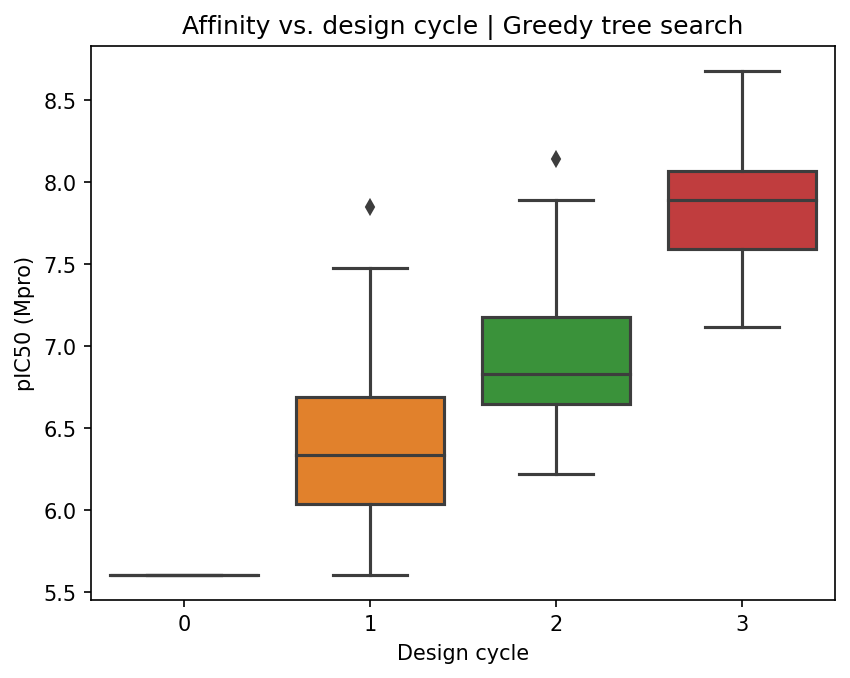

In [449]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library
g = sns.boxplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Affinity vs. design cycle | Greedy tree search')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (Mpro)')

plt.gcf().set_dpi(150)
plt.show()

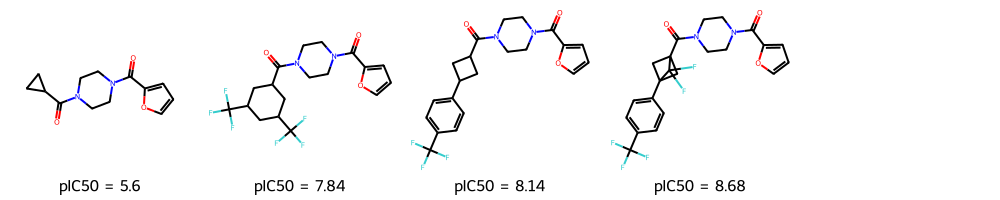

In [458]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, Draw

def align_to_origin(molecule):
    """
    Recursively aligns a molecule to its chain of inspirations, going back to the first molecule.

    Parameters
    ----------
    molecule : object
        An object having 'mol' as the RDKit molecule and 'inspiration' as another object 
        representing its inspiration. This chain should lead back to an origin molecule 
        which has 'inspiration' as None.

    Returns
    -------
    list
        A list of aligned RDKit molecule objects, starting from the origin.
    """
    aligned_molecules = []

    # Recursively find the origin molecule
    current_molecule = molecule
    while current_molecule.inspiration is not None:
        aligned_molecules.append(current_molecule)
        current_molecule = current_molecule.inspiration

    # Add the origin molecule
    aligned_molecules.append(current_molecule)

    # Reverse the list to start alignment from the origin
    aligned_molecules.reverse()

    # Generate 3D coordinates for all molecules if not already present
    for molecule in aligned_molecules:
        mol = molecule.mol
        AllChem.Compute2DCoords(mol)

    # Align each molecule with its inspiration
    for i in range(1, len(aligned_molecules)):
        current_mol = aligned_molecules[i].mol
        inspiration_mol = aligned_molecules[i-1].mol

        # Find MCS between current molecule and its inspiration
        mcs_result = rdFMCS.FindMCS([current_mol, inspiration_mol])
        mcs_smarts = mcs_result.smartsString
        if not mcs_smarts:
            continue  # Skip if no MCS is found

        mcs_mol = Chem.MolFromSmarts(mcs_smarts)

        # Align the molecule to its inspiration based on MCS
        match1 = current_mol.GetSubstructMatch(mcs_mol)
        match2 = inspiration_mol.GetSubstructMatch(mcs_mol)
        if match1 and match2:
            AllChem.AlignMol(current_mol, inspiration_mol, atomMap=list(zip(match1, match2)))

    return [molecule for molecule in aligned_molecules]

def plot_aligned_molecules(molecules):
    """
    Plots a list of RDKit molecules.

    Parameters
    ----------
    molecules : list
        A list of RDKit molecule objects.
    """
    annotations = [f'pIC50 = {round(m.annotations["ADAM17 affinity"], 2)}'
                   if 'ADAM17 affinity' in m.annotations else '' for m in molecules]
    mols = [m.mol for m in molecules]
    img = Draw.MolsToGridImage(
        mols,
        subImgSize=(200, 200),
        molsPerRow=5,
        legends=annotations
    )
    return img

mol = drug_env.library[0]
mol.update_annotations(
    {'ADAM17 affinity': docking_utility.oracle([mol])[0]}
)

aligned_molecules = align_to_origin(drug_env.library.annotated[-1])
plot_aligned_molecules(aligned_molecules)